# 4.2 Extracció de Keypoints: SIFT, SURF, HOG

## Keypoints
Els Keypoints o punts característics o punts d'interès d’una imatge són aquells punts que són fàcilment diferenciables en una imatge i que ens permeten identificar-los en imatges iguals o similars a les quals se’ls ha aplicat alguna transformació com escalatge, rotacions, etc.

Són punts importants quant a la informació de l’entorn que representen, però també estables quant a transformacions locals i globals de la imatge.

Si els Blobs eren _regions_ de la imatge d’especial interès, els Keypoints són els _punts d’interès_ de la imatge, la majoria de vegades també són part d’un Blob o del seu límit. Són considerats un subconjunt dels Blobs o un submètode de la detecció de Blobs. La idea és que no importa com i quant canviï una imatge, pot escalar-se, rotar-se, traslladar-se o distorsionar-se, però els mètodes de detecció dels keypoints trobaran els mateixos en tots els casos.


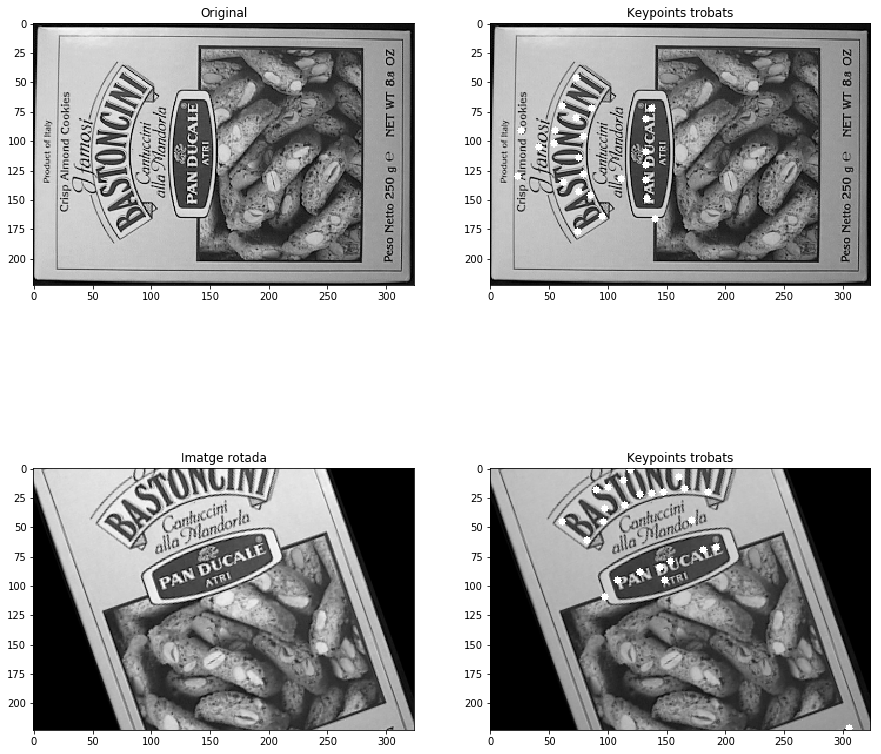

In [16]:
#EXEMPLE PRÀCTIC: detecció keypoints en dues imatges iguals però amb diferent orientació
import cv2
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def build_keypoints_img(img):
    """
    Obtenim els punts d'interés de la imatge d'entrada i retorna una nova imatge amb els
    punts d'interés dibuixats
    """
    corners = cv2.goodFeaturesToTrack(img,25,0.01,10)
    img_keypoints = img.copy()
    corners = np.int0(corners)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img_keypoints,(x,y),3,255,-1)
    return img_keypoints

    
im = cv2.imread('Imatges/box.png', cv2.IMREAD_GRAYSCALE)

# creem una matriu de rotació per rotar la imatge 40 graus agafant el centre de la imatge com a eix de rotació
center = (im.shape[1]//2, im.shape[0]//2)
angle = -70
scale = 1.1
rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
# apliquem la matriu de rotació i escalat
im_rotada = im
im_rotada = cv2.warpAffine(im, rot_mat, (im_rotada.shape[1], im_rotada.shape[0]))

# trobem els keypoints en ambdós imatges
img_keypoints = build_keypoints_img(im)
img_keypoints_rotada = build_keypoints_img(im_rotada)

# veiem com els punts detectats són molt similars, encara que la imatge estigui transformada amb una rotació i escalat

# mostrem resultats
plt.subplot(2,2,1)
plt.title('Original')
plt.imshow(im, cmap='gray')

plt.subplot(2,2,2)
plt.title('Keypoints trobats')
plt.imshow(img_keypoints, cmap='gray')

plt.subplot(2,2,3)
plt.title('Imatge rotada')
plt.imshow(im_rotada, cmap='gray')

plt.subplot(2,2,4)
plt.title('Keypoints trobats')
plt.imshow(img_keypoints_rotada, cmap='gray')


fig = plt.gcf()
fig.set_size_inches(15, 15)


Existeixen diversos mètodes de detecció o extracció de Keypoints, però hem de tenir en compte que la majoria només ens dóna informació de la seva posició en la imatge, és a dir, les seves coordenades, la qual cosa no és suficient per establir una relació entre ells, ni per veure si són semblants o molt diferents entre ells. Per aconseguir aquesta informació, necessitem els **descriptors** dels keypoints, perquè ells són els que en donen una manera de comparar els keypoints entre sí.

Imaginem que tenim dues imatges iguals on una és una còpia de l’altra però traslladada nomes uns píxels a la dreta respecte la primera. Si només tinguéssim els Keypoints, tot i ser exactament els mateixos perquè són dues imatges iguals, com veuríem només la posició els identificaríem com keypoints diferents i, per tant, com imatges diferents. I ens passaria el mateix si una imatge fos el doble de l’altra. Els descriptors seran els que ens permetran _comparar_ keypoints de diferents imatges i detectar-los com iguals.

Anem a veure un exemple de com fer servir aquestes propietats per tal de buscar objectes coneguts en imatges arbitràries


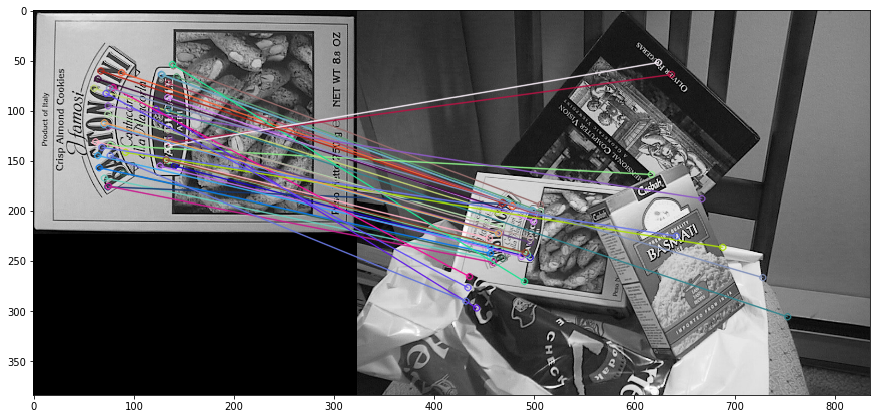

In [17]:
#EXEMPLE PRÀCTIC: càlcul descriptors i matching de keypoints 
# En aquest cas, farem servir un detector basat en FAST i un descriptor anomenat ORB
# L'objectiu serà trobar la imatge 1 dins de la imatge 2
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('Imatges/box.png',0) 
img2 = cv2.imread('Imatges/box_in_scene.png',0)

# Inicialitzem el descriptor 
orb = cv2.ORB_create()

# obtenim els keypoints i els seus descriptors
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# un cop tenim els keypoints i descriptors d'ambdós imatges, intentem aparellar-los per força bruta
# (buscant les associacions amb mínima distància de hamming)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

# Els ordenem per distància
matches = sorted(matches, key = lambda x:x.distance)

# Mostrem els 10 més similars
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:40], None,flags=2)

plt.imshow(img3)

fig = plt.gcf()
fig.set_size_inches(15, 15)


Els descriptors desen informació relativa al keypoint en format numèric en una variable tipus vector. D’aquesta manera comparar keypoints es redueix a comparar vectors numèrics, la qual cosa es pot fer de diverses maneres però una simple distància euclidiana pot ser més que suficient per la majoria dels casos.

Els descriptors han de complir unes característiques bàsiques:
- Han de ser independents de la posició del keypoint: és a dir que si movem la imatge i extraiem el mateix keypoint, el descriptor ha de ser el mateix.
- Han de ser robusts a les transformacions d’imatge: canvis en el contrast (mateixa imatge amb sol o sense sol), o canvis en la perspectiva de l’objecte haurien de donar els mateixos descriptors.
- Han de ser independents a l’escalatge de la imatge.

Com ja hem comentat, hi ha molts algoritmes per extreure Keypoints, molts d’ells es basen només en la detecció de cantonades perquè són més fàcils de trobar i són invariants a les rotacions, però en molts casos no són invariants a l’escalatge. Nosaltres, en aquest curs, veurem alguns algoritmes que van més enllà i aconsegueixen localitzar característiques invariants a les rotacions, l’escalatge, canvis en la il·luminació i en els punts de vista. Comencem per l’algoritme SIFT.

## SIFT
SIFT és l’acrònim del seu nom en anglès Scale Invariant Feature Transform i és un algoritme de localització i descripció de keypoints que va ser publicat per primer cop el 1999 (i patentat el 2004).

Està basat en el càlcul dels gradients dels píxels i els seus veïns, el que permet localitzar i identificar el mateix keypoint en diverses imatges independentment de la rotació i escala aplicada.

El procés per detectar-los segueix els següents passos:
1. Crear un espai a escala: Es difumina i remodela la imatge amb diferents amplades de difusió i taxes de mostreig per crear un espai a escala. A la imatge original se li aplica diferents nivells de difuminació (recomanen 5 nivells) i diferents nivells d’escalatge (recomanen uns 4), és a dir que es creen diferents representacions internes de la imatge original. (La imatge original es difumina diverses vegades, es re-escala a la meitat de la mida i es tornen a aplicar els nivells de difuminació, es torna a escalar a la meitat de la mida, etc. ). Cada grup d’imatges de la mateixa mida però amb difuminació diferent s’anomena octava.
2. Invariància escalar: Per cada parell d’imatge d’una mateixa octava, es calcula la Diferència de Gaussianes (DoG en anglès), i a partir d’aquí es calculen els màxims i mínims comparant els píxels d’una imatge amb la corresponent de l’anterior i posterior octava. Com a resultat detectarem blobs a diferents escales. El centre del blob es converteix en un keypoint donada una escala, x i y. 
3. Invariància rotacional: Assignar a cada keypoint una orientació calculant l’histograma de les orientacions del gradient per a cada píxel i els seus veïns, i escollint aquell que tingui més importància o prominència (el que tingui més aparicions).
4. Identificació única de cada keypoint: Assignar a cada keypoint un vector de característiques de 128 dimensions basat en les orientacions dels gradients dels píxels i els seus 16 veïns locals. Aquest identificador únic també es coneix com fingerprint del keypoint.


El mètode SIFT permet identificar els mateixos objectes o punts d’interès en diferents imatges independentment de l’escala, la rotació, la il·luminació i el punt de vista. Funciona molt bé, però és un algoritme patentat, el que vol dir que el podem fer servir amb finalitats acadèmiques, però no per finalitats comercials a no ser que s’arribi a un acord amb els autors.

## SURF
SURF ve del seu acrònim en anglès Speeded-Up Robust Features, va ser creat després de l’algoritme de SIFT, en el 2006, amb la intenció de millorar la velocitat i rendiment d’aquest últim. Igual que SIFT, aquest també és un algoritme patentat per a la detecció i descripció de keypoints en una imatge.

SURF millora cadascun dels passos de l’algoritme de SIFT, per exemple utilitza convolució amb Box Filter enlloc de calcular les DoG, el mètode de la determinant de Hessian per detectar blobs, les respostes horitzontals i verticals a les ones de Harr per calcular l’orientació dominant i, finalment, desa els descriptors resultants en un vector de 64 dimensions. L’algoritme és 3 vegades més ràpid que el SIFT i, tot i així, continua sent robust en la majoria de situacions d’escalatge i rotació, tot i que no és tant bo com el SIFT per canvis en il·luminació i punts de vista.


## HOG
L’algoritme HOG (del seu nom en anglès Histogram of Oriented Gradients) es va fer popular al 2005, tot i que es van publicar i patentar alguns dels seus conceptes molt abans, a finals dels 90. En aquest algoritme, la distribució de la orientació dels gradients és el que es fa servir com característiques.

Com ja hem explicat en el capítol anterior (4.1 Contorns), es pot calcular l’aproximació al gradient a través de la convolució amb l’operador Sobel, el qual utilitza dues matrius 3x3 (kernels), una per calcular els canvis horitzontals i l’altre pels canvis verticals.

Les matrius s'apliquen a cada píxel, el que ens donarà per cada bloc de 64 píxels (8x8) un resultat de 64 vectors gradients. Aquest resultat es comprimeix en 9 vectors, creant un histograma de vectors gradient on l’eix de les $\begin{equation}x\end{equation}$ són els possibles valors de la direcció (mostrejats en blocs de 20 graus), i l’eix de les $\begin{equation}y\end{equation}$ són els valors de les possibles magnituds.

<img src='Imatges/hog_histograms.png'>


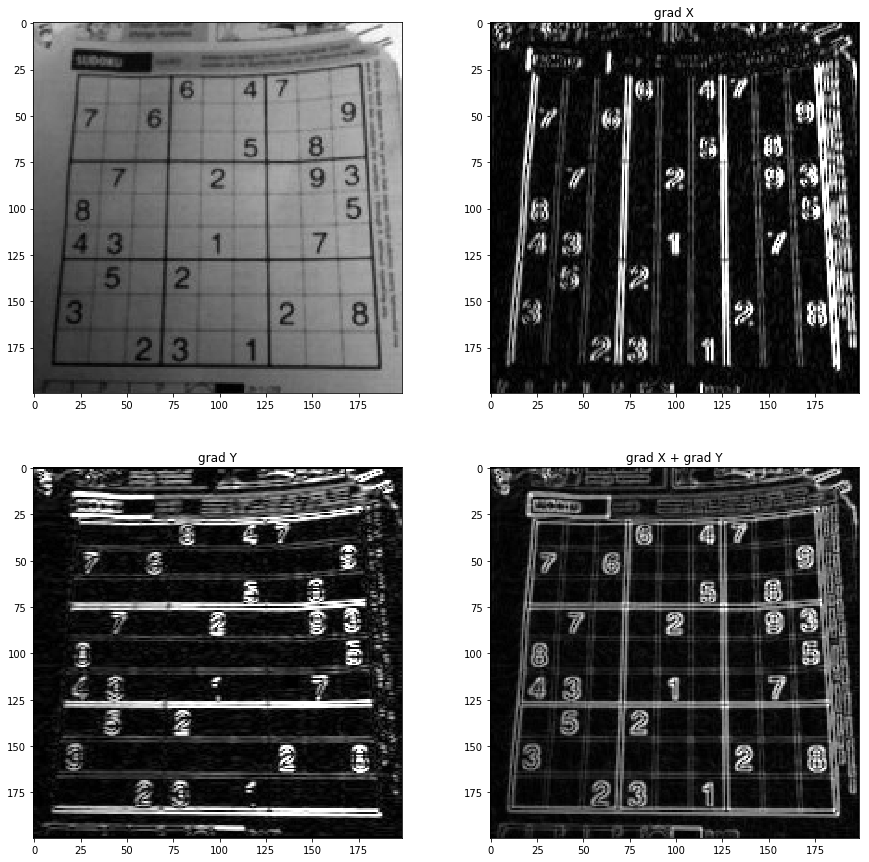

In [13]:
#EXEMPLE PRÀCTIC: CALCULAR I MOSTRAR ELS GRADIENTS HORITZONTALS I VERTICAL D’UNA IMATGE, AIXÍ COM LA 
# COMBINACIÓ DELS DOS AMB MÈTODE HOG (o matrius SOBEL)

import cv2
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

scale = 1
delta = 0
ddepth = cv2.CV_16S
    
im = cv2.imread('Imatges/sudoku.jpg', cv2.IMREAD_GRAYSCALE)

# https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
grad_x = cv2.Sobel(im, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(im, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

plt.subplot(2,2,1)
plt.imshow(im, cmap='gray')
plt.subplot(2,2,2)
plt.title('grad X')
plt.imshow(abs_grad_x, cmap='gray')
plt.subplot(2,2,3)
plt.title('grad Y')
plt.imshow(abs_grad_y, cmap='gray')
plt.subplot(2,2,4)
plt.title('grad X + grad Y')
plt.imshow(grad, cmap='gray')
fig = plt.gcf()
fig.set_size_inches(15, 15)



## FAST i ORB
Finalment, acabem amb els algoritmes que hem fet servir en el segon exemple pràctic d'aquest capítol, els algoritmes FAST i ORB.

**FAST** (de l'anglès _Features from Accelerated Segment Test_) va ser originàriament desenvolupat al 2006 per detectar punts d'interès en aplicacions en temps real. És un mètode de detecció de cantonades que es pot utilitzar per extreure punts característics i, posteriorment, utilitzar-se per detectar objectes en moltes tasques de visió per computador.

La seva idea principal és comparar només píxels en un cercle de radi fix al voltant d'un píxel central. Donat un píxel $\begin{equation}p\end{equation}$ d'una matriu, es compara ràpidament la brillantor de $\begin{equation}p\end{equation}$ amb els 16 píxels dels voltant (els que estan dins el cercle amb centre $\begin{equation}p\end{equation}$). Si la majoria de píxels (més de 8) són més foscos o més brillants que $\begin{equation}p\end{equation}$, es selecciona $\begin{equation}p\end{equation}$ com a punt d'interès. D'aquesta manera el càlcul del punts d'interès és molt ràpid i ens proporcionen informació sobre la ubicació dels contorns determinants d'una imatge.

<center>
    <img src="Imatges/The-corner-detection-by-using-FAST-algorithm-15.png"><br>
    <a href="https://www.researchgate.net/publication/267638940_Image_Stitching_based_on_Feature_Extraction_Techniques_A_Survey#pf4">Detecció de punts d'interès aplicant mètode FAST </a>
</center>
    
El càlcul de punts d'interès amb el mètode FAST és molt ràpid però, per altra banda, la seva principal limitació és que es detecten múltiples punts característics adjacents.

El mètode **ORB** (de l'anglès _**O**riented FAST and **R**otated **B**RIEF_) és un descriptor binari molt ràpid basat en el descriptor de punts d'interès BRIEF (de l'anglès _Binary Robust Independent Elementary Features_). És el més recent dels que expliquem en aquest capítol, va ser desenvolupat al 2011.

BRIEF és un mètode per descriure punts d'interès, però no és un mètode per detectar els punts d'interès. Normalment s'ha d'utilitzar junt amb algun altre mètode que localitzi els punts d'interès i llavors aplicar el BRIEF per extreure els descriptors. 

Com el seu propi nom indica, el tipus de descriptor que calcula el BRIEF ja no és un vector de 128 dimensions (com en el SIFT), ni de 64 (com en SURF), sinó un descriptor binari. Els descriptors binaris són més eficients que els descriptors basats en vectors per diverses raons: poden ser més ràpids de calcular, són més eficients per ser comparats i requereixen molta menys memòria. L'ORB és dues ordres de magnitud més ràpid que el SIFT. 

ORB fusiona el detector de punts d'interès FAST amb el descriptor BRIEF i, a més, els afegeix diverses modificacions per millorar-ne el rendiment i la funcionalitat: per exemple, té en compte que FAST no calcula la orientació i aplica una capa per solucionar-ho i, també té en compte i soluciona que BRIEF funcioni malament amb les rotacions. L'article original diu que ORB és molt més ràpid que SIFT i SURF, i que els descriptors que extreu funcionen millor que el SURF.




## Referències
1. Contorns
 - Understading features: [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_meaning/py_features_meaning.html](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_meaning/py_features_meaning.html)
 - Contours : Getting Started: [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started)
 - Contours in OpenCV: [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_table_of_contents_contours/py_table_of_contents_contours.html#table-of-content-contours](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_table_of_contents_contours/py_table_of_contents_contours.html#table-of-content-contours)
 - Contour Features: [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#contour-features](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#contour-features)
 - Contour Properties: [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html#contour-properties](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html#contour-properties)
 - Valverde-Rebaza, Jorge. (2007). Detección de bordes mediante el algoritmo de Canny. [https://www.researchgate.net/publication/267240432_Deteccion_de_bordes_mediante_el_algoritmo_de_Canny](https://www.researchgate.net/publication/267240432_Deteccion_de_bordes_mediante_el_algoritmo_de_Canny)

2. SIFT
 - Un bon tutorial de SIFT: SIFT: Theory and Practice [http://www.aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/](http://www.aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/)
 - SIFT en OpenCV: [https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html)

3. SURF
 - Introduction to SURF (Speeded-Up Robust Features): [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html)

4. HOG
 - Histogram of Oriented Gradients: [https://www.learnopencv.com/histogram-of-oriented-gradients/](https://www.learnopencv.com/histogram-of-oriented-gradients/)
 - Operador Sobel en la Wiki: [https://es.wikipedia.org/wiki/Operador_Sobel](https://es.wikipedia.org/wiki/Operador_Sobel)
 - Video explicatiu algoritme HOG pas a pas, Centre Recerca Visió per Computador, Universitat de Florida Centre: [https://www.youtube.com/watch?v=0Zib1YEE4LU](https://www.youtube.com/watch?v=0Zib1YEE4LU)

5. FAST
 - Adel, Ebtsam & Elmogy, Mohammed & El-Bakry, Hazem. (2014). Image Stitching based on Feature Extraction Techniques: A Survey. International Journal of Computer Applications. 99. 1-8. 10.5120/17374-7818.: [https://www.researchgate.net/publication/267638940_Image_Stitching_based_on_Feature_Extraction_Techniques_A_Survey#pf4](https://www.researchgate.net/publication/267638940_Image_Stitching_based_on_Feature_Extraction_Techniques_A_Survey#pf4)
 - FAST Algorithm for Corner Detection: [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_fast/py_fast.html](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_fast/py_fast.html)
 - Introduction to FAST (Features from Accelerated Segment Test): [https://medium.com/software-incubator/introduction-to-fast-features-from-accelerated-segment-test-4ed33dde6d65](https://medium.com/software-incubator/introduction-to-fast-features-from-accelerated-segment-test-4ed33dde6d65)

6. ORB
 - ORB Paper: [http://www.willowgarage.com/sites/default/files/orb_final.pdf](http://www.willowgarage.com/sites/default/files/orb_final.pdf)
 - BRIEF (Binary Robust Independent Elementary Features): [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_brief/py_brief.html#brief](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_brief/py_brief.html#brief)
 - ORB (Oriented FAST and Rotated BRIEF): [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html#orb](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html#orb)
 - Introduction to ORB (Oriented FAST and Rotated BRIEF): [https://medium.com/software-incubator/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf](https://medium.com/software-incubator/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)
